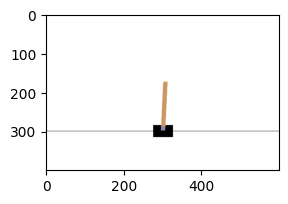

In [ ]:
'''
* 作用: 建立遊戲環境。
* `gym`: 這是 OpenAI 提供的強化學習工具包，用來建立和互動各種標準化的環境。
* `MyWrapper`: 這是一個自訂的環境包裝器，它對原始的 CartPole-v1 環境做了一些修改：
    * 限制最大步數: 強制遊戲在 200 步後結束。
    * 修改獎勵: 如果在 200 步之前就失敗了 (杆子倒了)，會給一個 -1000 的巨大負分作為懲罰。這能強烈地驅使模型學會堅持更久。
* `env.show()`: 最後，它會顯示一幀遊戲畫面，讓我們看到初始狀態。
'''

import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [ ]:
'''
* 作用: 建立策略網路 (Policy Network)。
* 輸入: 遊戲的狀態 (4個數字：車子位置、速度、杆子角度、角速度)。
* 輸出: 一個包含2個數字的陣列，代表向左和向右移動的機率。
* `Softmax`: 這是關鍵的激活函數，它能確保模型的輸出是合法的機率分佈 (兩個數字相加等於1)。
'''

import torch

#定义模型,计算每个动作的概率
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

In [ ]:
'''
* 作用: 完整地玩一局遊戲，並收集這局的所有數據。
* 核心邏輯:
    1. 在每一步，將當前狀態 s 輸入模型，得到向左/向右的機率 prob。
    2. 使用 random.choices 根據這個機率分佈來隨機抽樣一個動作 a。這就是策略梯度的核心——不是每次都選機率最高的，而是根據機率來探索。
    3. 記錄下這一步的 state, action, 和 reward。
    4. 重複直到遊戲結束。
* 返回: 返回這一整局的狀態、動作、獎勵序列，以及本局的總分。
'''

from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)

    return state, action, reward, reward.sum().item()


state, action, reward, reward_sum = play()

reward_sum

-961.0

In [ ]:
'''
* 作用: 執行訓練循環。
* 核心邏輯 (REINFORCE 演算法):
    1. `play()`: 先玩一局遊戲，收集數據。
    2. 計算價值 `value`: 這是 REINFORCE 的關鍵。它使用蒙地卡羅法來估計每個時間點的「未來總折扣獎勵」。對於第 i 步的狀態，它的價值是從第 i
        步到遊戲結束所有獎勵的折扣總和。0.99**(j - i) 就是折扣因子 $\gamma$。
    3. 計算機率 `prob`: 將遊戲中實際經過的狀態 state 重新丟入模型，計算出當時採取 action 的機率。
    4. 計算損失 `loss`: 損失函數的核心是 log(prob) * value。
        * log(prob): 這是策略梯度的標準部分。
        * * value: 這就是用蒙地卡羅估算出的未來總獎勵來加權。如果 value 是正的 (好結果)，就希望 log(prob) 變大 (即 prob 變大)；如果 value
            是負的 (壞結果)，就希望 log(prob) 變小。
        * loss = -prob.mean(): 因為優化器是最小化 loss，所以我們在前面加一個負號，就變成了最大化期望獎勵。
    5. 更新: 反向傳播並更新模型參數。
'''

#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    #训练N局
    for epoch in range(1000):

        #一个epoch最少玩N步
        steps = 0
        while steps < 200:

            #玩一局游戏,得到数据
            state, action, reward, _ = play()
            steps += len(state)

            #计算当前state的价值,其实就是Q(state,action),这里是用蒙特卡洛法估计的
            value = []
            for i in range(len(reward)):
                s = 0
                for j in range(i, len(reward)):
                    s += reward[j] * 0.99**(j - i)
                value.append(s)
            value = torch.FloatTensor(value).reshape(-1, 1)

            #重新计算动作的概率
            prob = model(state).gather(dim=1, index=action)

            #求Q最大的导函数 -> partial value / partial action
            prob = (prob + 1e-8).log() * value
            for i in range(len(prob)):
                prob[i] = prob[i] * 0.99**i
            loss = -prob.mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss.item(), test_result)


train()

0 -587.5588989257812 -980.75
100 14.519118309020996 200.0
200 14.342663764953613 200.0
300 14.979691505432129 148.3
400 14.759649276733398 148.2
500 14.41473388671875 200.0
600 15.143874168395996 200.0
700 14.560319900512695 200.0
800 15.542492866516113 200.0
900 13.918622016906738 200.0


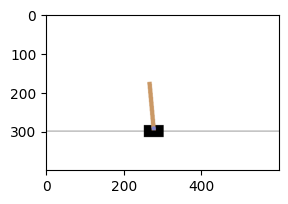

200.0

In [6]:
play(True)[-1]